<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Validate-with-ORNL-DAAC-Subset" data-toc-modified-id="Validate-with-ORNL-DAAC-Subset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Validate with ORNL DAAC Subset</a></span><ul class="toc-item"><li><span><a href="#Request-a-subset" data-toc-modified-id="Request-a-subset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Request a subset</a></span></li><li><span><a href="#Subset-CSVs" data-toc-modified-id="Subset-CSVs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Subset CSVs</a></span></li></ul></li><li><span><a href="#Validate-with-MCD43A3-Albedos" data-toc-modified-id="Validate-with-MCD43A3-Albedos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Validate with MCD43A3 Albedos</a></span></li></ul></div>

# Validation

## Validate with ORNL DAAC Subset

### Request a subset
You can get a subset like the one below (or for 20+ other MODIS/VIIRS land products) by visiting **https://modis.ornl.gov** and clicking the **Get Data** link. The subset that I used comes from the *Global Tool*; the daily MCD43 products are not available through the web service. I requested a random point somewhere in/near the everglades and the ORNL DAAC's backend computed the black, white, and blue sky albedos from the MCD43A1 parameters just like we did. Input parameters called for solar zenith angles calculated for **local noon** and the optical depth parameter was set to **0.20**:             
https://modis.ornl.gov/subsetdata/03Jul2019_13:43:49_346167250L28.27149L-81.9668S1L1_MCD43A/

### Subset CSVs

Download the CSVs for near-infrared black, white, and blue albedos and parse them to data frames:

In [1]:
%matplotlib inline
import requests
import numpy as np
import pandas as pd
import xarray as xr
from io import StringIO
from pyproj import Proj, transform
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib.pyplot as plt

order_nir = {"nir_black": None, "nir_white": None, "nir_actual": None}
order_url = ("https://modis.ornl.gov/subsetdata/"
             "03Jul2019_13:43:49_346167250L28.27149L-81.9668S1L1_MCD43A/")

# ugly lambda function parses modis dates to real dates
to_dt = lambda d: (dt(int(d[1:5]),1,1)+td(int(d[5:])-1)).strftime('%Y-%m-%d')

# iterate over list of nir CSVs
for csv in list(order_nir.keys()):   

    # download with requests.get
    r = requests.get(order_url+csv+".csv")    
        
    # read response text to df via StringIO pseudofile
    order_nir[csv] = pd.read_csv(
        StringIO(r.text), 
        header=None, 
        sep=",", 
        names=["id", "prod", "mdate", "loc", "pdate", "var", "data"]) 
    
    # set the data column to mask the fill values (32767.0)
    order_nir[csv].loc[order_nir[csv].data==32767.0, "data"] = np.nan
    
    # get dates from the third column (base zero); set to index
    order_nir[csv].index = [to_dt(date) for date in order_nir[csv]["mdate"]] 

    
order_nir["nir_black"].head(5)    # print first five rows of nir_black

,id,prod,mdate,loc,pdate,var,data
2018-01-01,MCD43A.A2018001.h10v06.006.2018010031010.nir_b...,MCD43A,A2018001,Lat28.27149Lon-81.9668Samp1Line1,2018010031010,nir_black,0.188892
2018-01-02,MCD43A.A2018002.h10v06.006.2018011031030.nir_b...,MCD43A,A2018002,Lat28.27149Lon-81.9668Samp1Line1,2018011031030,nir_black,0.183267
2018-01-03,MCD43A.A2018003.h10v06.006.2018012030820.nir_b...,MCD43A,A2018003,Lat28.27149Lon-81.9668Samp1Line1,2018012030820,nir_black,0.183281
2018-01-04,MCD43A.A2018004.h10v06.006.2018013032552.nir_b...,MCD43A,A2018004,Lat28.27149Lon-81.9668Samp1Line1,2018013032552,nir_black,0.183250
2018-01-05,MCD43A.A2018005.h10v06.006.2018014032359.nir_b...,MCD43A,A2018005,Lat28.27149Lon-81.9668Samp1Line1,2018014032359,nir_black,0.182639


Get lists of outputs for black, white, and blue:

In [2]:
import glob

bsa_result = glob.glob("result/black_albedo*.nc")
wsa_result = glob.glob("result/white_albedo*.nc")
alb_result = glob.glob("result/blue_albedo*.nc")

print("Black sky albedo outputs for 2018:"); bsa_result

Black sky albedo outputs for 2018:


['result/black_albedo_MCD43A1.2018_3.nc',
 'result/black_albedo_MCD43A1.2018_7.nc',
 'result/black_albedo_MCD43A1.2018_5.nc',
 'result/black_albedo_MCD43A1.2018_9.nc',
 'result/black_albedo_MCD43A1.2018_8.nc',
 'result/black_albedo_MCD43A1.2018_6.nc',
 'result/black_albedo_MCD43A1.2018_11.nc',
 'result/black_albedo_MCD43A1.2018_4.nc',
 'result/black_albedo_MCD43A1.2018_1.nc',
 'result/black_albedo_MCD43A1.2018_12.nc',
 'result/black_albedo_MCD43A1.2018_10.nc',
 'result/black_albedo_MCD43A1.2018_2.nc']

Ooops, sort those files. **File lists passed to `xr.open_mfdataset` must be sequential**:

In [3]:
bsa_result = sorted(bsa_result, key=lambda x: int(x.split("_")[-1][:-3]))
bsa_result

['result/black_albedo_MCD43A1.2018_1.nc',
 'result/black_albedo_MCD43A1.2018_2.nc',
 'result/black_albedo_MCD43A1.2018_3.nc',
 'result/black_albedo_MCD43A1.2018_4.nc',
 'result/black_albedo_MCD43A1.2018_5.nc',
 'result/black_albedo_MCD43A1.2018_6.nc',
 'result/black_albedo_MCD43A1.2018_7.nc',
 'result/black_albedo_MCD43A1.2018_8.nc',
 'result/black_albedo_MCD43A1.2018_9.nc',
 'result/black_albedo_MCD43A1.2018_10.nc',
 'result/black_albedo_MCD43A1.2018_11.nc',
 'result/black_albedo_MCD43A1.2018_12.nc']

Open the black albedo outputs as a single dataset (using `xr.open_mfdataset`):

In [4]:
bsa = xr.open_mfdataset(bsa_result)
bsa

<xarray.Dataset>
Dimensions:                           (time: 365, x: 1336, y: 1555)
Coordinates:
    lat                               (y, x) float64 31.0 31.0 ... 24.53 24.53
    lon                               (y, x) float64 -88.17 -88.17 ... -76.96
  * x                                 (x) float64 -8.404e+06 ... -7.785e+06
  * y                                 (y) float64 3.447e+06 ... 2.727e+06
    month                             (time) int64 dask.array<shape=(365,), chunksize=(31,)>
  * time                              (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
Data variables:
    solar_zenith_angle                (time, y, x) float64 dask.array<shape=(365, 1555, 1336), chunksize=(31, 1555, 1336)>
    crs                               (time) int8 -127 -127 -127 ... -127 -127
    BRDF_Albedo_Parameters_Band1      (time, y, x) float64 dask.array<shape=(365, 1555, 1336), chunksize=(31, 1555, 1336)>
    BRDF_Albedo_Parameters_Band2      (time, y, x) float64 dask.a

Now extract the time series for the same pixel that was requested from ORNL DAAC. First we need to get the lat,lon coordinate in Sinusoidal meters so that we can index the array (*please excuse the absurd string parse job*):

In [5]:
ll = order_nir["nir_black"].iloc[0]["loc"].split("Samp")[0][3:].split("Lon")
ll

['28.27149', '-81.9668']

We need to use Sinusoidal coordinates to safely index our dataset. The following transform is the exact opposite of the one that we used to generate latitude and longitude arrays in [1_Workflow.ipynb](1_Workflow.ipynb):

In [6]:
# EPSG code for geographic WGS84 is our input projection this time
inproj = Proj(init="epsg:4326")

# build the MODIS sinusoidal proj4 string again
getpar = lambda a: str(bsa.crs.attrs[a])
outproj = Proj(" ".join([
    "+proj=sinu",
    "+lon_0="+getpar("longitude_of_central_meridian"),
    "+x_0="+getpar("false_easting"),
    "+y_0="+getpar("false_northing"),
    "+a="+getpar("semi_major_axis"),
    "+b="+getpar("semi_minor_axis"),
    "+units="+"meter +no_defs"]))

# pass the two projection definitions to transform along with the lat,lon
x,y = transform(inproj, outproj, float(ll[1]), float(ll[0]))

print("Sinusoidal equivalent for the lat, lon from the DAAC subset:"); x,y

Sinusoidal equivalent for the lat, lon from the DAAC subset:


(-8027086.119432877, 3143649.800007406)

Get the coordinate from the *x and y* dimensions that is nearest to the newly transformed coordinate:

In [7]:
import numpy as np

find_nearest = lambda array, value: array[(np.abs(array - value)).argmin()]
x_near = find_nearest(bsa.x, x).data.item()
y_near = find_nearest(bsa.y, y).data.item()

print("The nearest x,y coordinate in our dataset:"); x_near, y_near

The nearest x,y coordinate in our dataset:


(-8027124.470202017, 3143808.4379992373)

Finally, index the array and plot:
1. our calculated black sky albedo time series for the near-infrared band,
2. the time series calculated by ORNL DAAC, and,
3. the difference of the two time series

Select black sky albedo arrays, select pixel, put it all in a data frame. Include SZA:

In [8]:
our_nir_bsa  = bsa["BRDF_Albedo_Parameters_nir"]  # get nir BSA for our ds
ornl_nir_bsa = order_nir["nir_black"]["data"]     # get nir BSA for subset

# select only the numpy arrays
sza = bsa["solar_zenith_angle"].sel(x=x_near, y=y_near).data.compute()
ours  = our_nir_bsa.sel(x=x_near, y=y_near).data.compute()
ornls = ornl_nir_bsa.values
diff  = ours-ornls

# make a df
df = pd.DataFrame({
    "ORNLDAAC": ornls, 
    "OURWORKFLOW": ours, 
    "DIFFERENCE": diff,
    "SZA": sza
}, index=bsa.time.dt.dayofyear)

df.head(5)

,ORNLDAAC,OURWORKFLOW,DIFFERENCE,SZA
dayofyear,,,,
1,0.188892,0.188894,0.000002,51.303762
2,0.183267,0.183269,0.000002,51.224372
3,0.183281,0.183284,0.000003,51.138180
4,0.183250,0.183253,0.000003,51.045213
5,0.182639,0.182642,0.000003,50.945498


Plot the data frame:

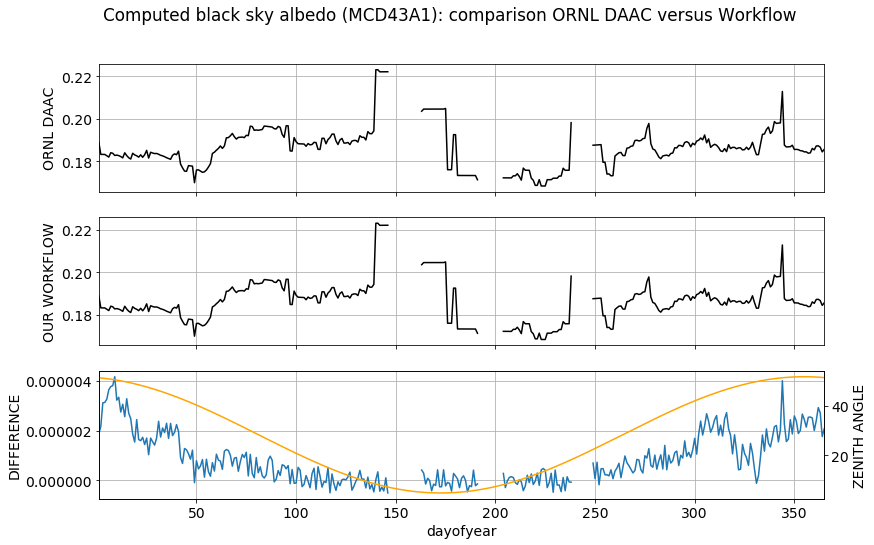

In [15]:
plt.rcParams['font.size'] = 14 

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(13,8))
fig.suptitle("Computed black sky albedo (MCD43A1): comparison "
             "ORNL DAAC versus Workflow")

df["ORNLDAAC"].plot(ax=axs[0], color="black")
axs[0].set_ylabel("ORNL DAAC")
axs[0].grid(True)

df["OURWORKFLOW"].plot(ax=axs[1], color="black")
axs[1].set_ylabel("OUR WORKFLOW")
axs[1].grid(True)

df["DIFFERENCE"].plot(ax=axs[2])
axs[2].set_ylabel("DIFFERENCE")
axs[2].grid(True)

axs3 = axs[2].twinx()
df["SZA"].plot(ax=axs3, color="orange")
axs3.set_ylabel("ZENITH ANGLE")

#fig.tight_layout()
plt.show()

Better than I expected.

It looks like the difference is related to the solar zenith angle because the concave time series resembles the solar zenith angle curve through the year. 

I can tell you with a lot of confidence that the tiny disparity (see y-axis precision) between the two time series comes from the ORNL DAAC's solar zenith angle calculator because it returns five decimal places. We're using the full precision solar zenith angle calculated by:

```shell

# parameters

doy = 166                         # day of the year    
diy = 365                         # number of days in the year
deg_rot_per_day = 360/diy         # degree of rotation per day
abs_max_declination = 23.45       # unsigned max declination

# declination is calculated by:
declination = cos(radians((doy+10)*deg_rot_per_day))*-abs_max_declination

# solar altitude (when given in angular units) and zenith are complementary angles
solar_altitude = 90 - latitude + declination
solar_zenith = 90 - solar_altitude


```

So, I'm satisfied with this and won't do any further validation for now.

## Validate with MCD43A3 Albedos 
*(coming soon)*